# Pfam dataset analysis

* The data can be used to create a model in order to predict the function of protein domain, which are functional sub-parts of proteins. 
* To make the task easier the data is presegmented so that it contains exactlt only one domain.

<b> Goal</b>: given the amino acid sequance of a protein domain, we should predict in which class it belongs to. 

<b> Dataset</b>  :
* 1 million training examples
* 18,000 output classes 

Package imports

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os

Folder "random_split" containing Pfam dataset from Kaggle :

(change folder path if necessary)

In [3]:
path="../random_split"
print(os.listdir(path))

['dev', 'random_split', 'test', 'train']


Each folder (train, dev, test) contains several files.
Each of those files contains a csv on each line with following fields :
* sequence : model input feature . It is the amino acid sequence for the domain.
* family_accession : labels for the model. Form is PFxxxxx.y, where xxxxx is the family accession, and y is the version number.                                
* sequence_name :  form "\$uniprotaccessionid/\$startindex-$end_index"
* aligned_sequence : Contains a single sequence from the multiple sequence alignment 
* family_id : One word name for family

It is illustrated in the following example taken from train folder.


In [3]:
data = pd.read_csv("../random_split/train/data-00011-of-00080")
data.head()

,family_id,sequence_name,family_accession,aligned_sequence,sequence
0,YfcL,Q5E3V0_VIBF1/3-85,PF08891.11,IEFEEKMLELIDARIESASD.DELFAGGYLRGHISLSVANCEEQGI...,IEFEEKMLELIDARIESASDDELFAGGYLRGHISLSVANCEEQGIN...
1,Somatomedin_B,F2UGX0_SALR5/258-297,PF01033.17,TTCAVRG...C..........SDINL......NQNCQCD.PSC.YS...,TTCAVRGCSDINLNQNCQCDPSCYSFGDCCADFAAVCESS
2,Surp,K7J3U9_NASVI/11-59,PF01805.20,RNIIDKLAQFVA..R..NG....P........EFEQMT.KNK.......,RNIIDKLAQFVARNGPEFEQMTKNKQKDNPKFSFLFGGEYFNYYQYKVT
3,DUF1230,E1ZG39_CHLVA/70-212,PF06799.11,.AVPREQRPVNELQQLKDTPLLAW......ATLDL..PQYAQRL.....,AVPREQRPVNELQQLKDTPLLAWATLDLPQYAQRLLILYGGVFLLL...
4,SRCR_2,F1NY88_CHICK/145-241,PF15494.6,GPNFILEVYSPVSQTWYPVCQDDWTDDFGKIACEDMGYN....VDT...,GPNFILEVYSPVSQTWYPVCQDDWTDDFGKIACEDMGYNVDTYYYS...


Folders analysis

In [4]:
def read_folder(partition='dev', data_dir=path):
    shards = []
    for fn in os.listdir(os.path.join(data_dir, partition)):
        with open(os.path.join(data_dir, partition, fn)) as f:
            shards.append(pd.read_csv(f, index_col=None))
    return pd.concat(shards)

test = read_folder('test')
dev = read_folder('dev')
train = read_folder('train')

partitions = {'test': test, 'dev': dev, 'train': train}
for name, df in partitions.items():
    print('Dataset partition "{}" has {} sequences'.format(name, len(df)))

Dataset partition "test" has 126171 sequences
Dataset partition "dev" has 126171 sequences
Dataset partition "train" has 1086741 sequences


### Most frequent family ids 

In [5]:
dev.groupby('family_id').size().sort_values(ascending=False).head(10)

family_id
Methyltransf_25    454
LRR_1              240
Acetyltransf_7     219
His_kinase         192
Bac_transf         190
Lum_binding        187
DNA_binding_1      168
Chromate_transp    157
Lipase_GDSL_2      156
DnaJ_CXXCXGXG      151
dtype: int64

### Distribution of family ids

[Text(0.5, 0, 'Family size'), Text(0, 0.5, 'Count')]

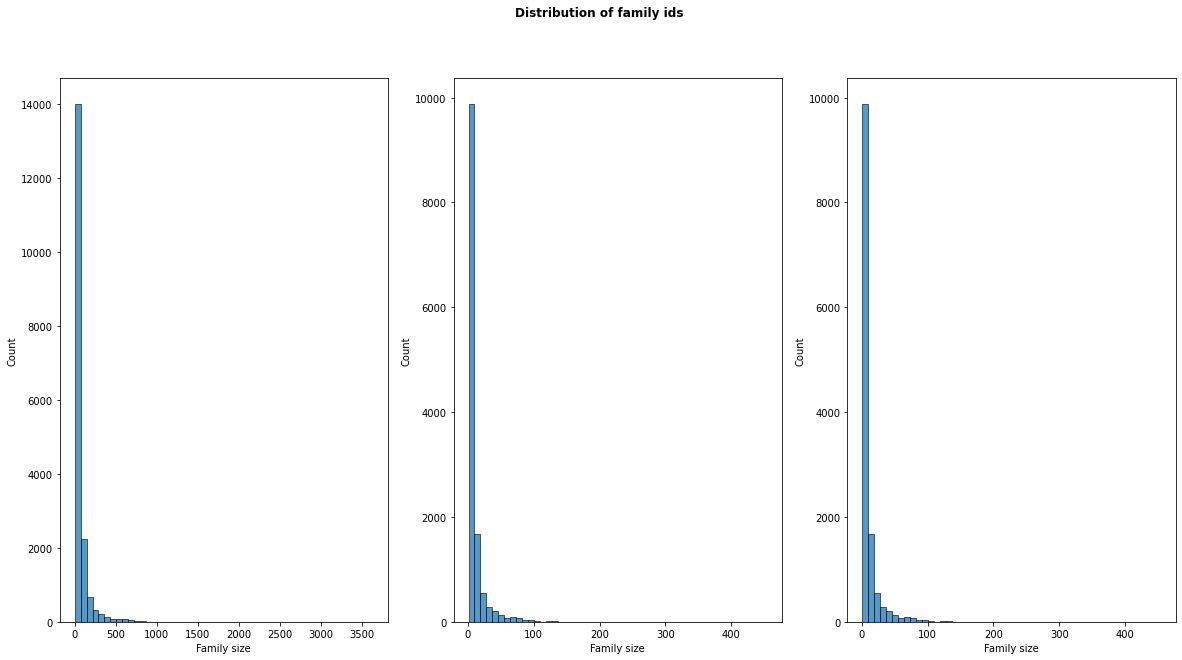

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(20, 10),sharex=True)
fig.suptitle('Distribution of family ids',fontweight="bold")
ax[0].set_title("train")
ax[1].set_title("dev")
ax[2].set_title("test")
plt.subplot(1, 3, 1)
train_plot=sns.histplot(data=train.groupby('family_id').size(),bins=50)
train_plot.set(xlabel="Family size",ylabel="Count")
plt.subplot(1, 3, 2)
dev_plot= sns.histplot(dev.groupby('family_id').size(),bins=50)
dev_plot.set(xlabel="Family size",ylabel="Count")
plt.subplot(1, 3, 3)
test_plot=sns.histplot(test.groupby('family_id').size(),bins=50)
test_plot.set(xlabel="Family size",ylabel="Count")



### Distribution of alignment lengths for train dataset

Text(0, 0.5, 'Number of sequences')

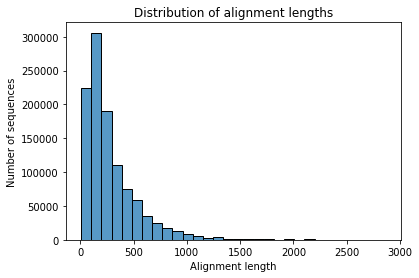

In [15]:
train['alignment_length'] = train.aligned_sequence.str.len()
sns.histplot(train.alignment_length,bins=30)
plt.title('Distribution of alignment lengths')
plt.xlabel('Alignment length')
plt.ylabel('Number of sequences')

### Overview of family lengths by family ids

In [17]:
family_lengths = (train[['family_id', 'alignment_length']]
                  .drop_duplicates()
                  .sort_values(by='alignment_length', ascending=False))

family_lengths.head(5)

,family_id,alignment_length
7433,Nup192,2866
4359,CobN-Mg_chel,2394
6151,GREB1,2260
26,PHO4,2197
9930,Arena_RNA_pol,2177


In [11]:
family_lengths.tail(5)

,family_id,alignment_length
944,Extensin_1,10
6137,Sperm_act_pep,10
1156,Involucrin,10
5508,YLP,9
2952,LSPR,9


### Amino acids frequencies in datasets

In [15]:
from collections import Counter
def get_frequency_amino_acids(df):  
  df = df.apply(lambda x: " ".join(x))
  
  codes = []
  for i in df: # concatination of all codes
    codes.extend(i)

  codes_dict= Counter(codes)
  codes_dict.pop(' ') # removing white space
  df = pd.DataFrame({'Code': list(codes_dict.keys()), 'Freq': list(codes_dict.values())})
  return df.sort_values('Freq', ascending=False).reset_index()[['Code', 'Freq']]

In [17]:
get_frequency_amino_acids(train['sequence'])

,Code,Freq
0,L,17062816
1,A,14384873
2,V,11913147
3,G,11845579
4,E,10859966
5,S,10597822
6,I,10234455
7,R,9406165
8,D,9371097
9,K,9127832


In [12]:
 def plot_code_freq(df, data_name):
  plt.title(f'Code frequency: {data_name}')
  sns.barplot(x='Code', y='Freq', data=df)

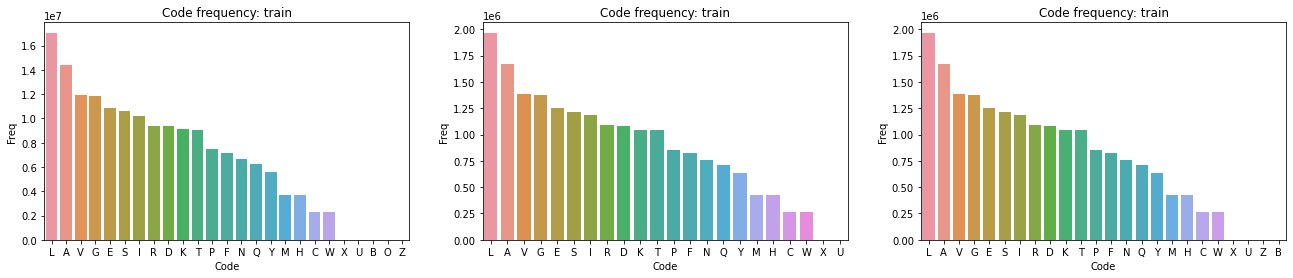

In [23]:
plt.subplot(1, 3, 1)
plot_code_freq(get_frequency_amino_acids(train['sequence']),"train")
plt.subplot(1, 3, 2)
plot_code_freq(get_frequency_amino_acids(dev['sequence']),"dev")
plt.subplot(1, 3, 3)
plot_code_freq(get_frequency_amino_acids(test['sequence']),"test")
plt.subplots_adjust(right=3.0)